
# Default Libraries Installation

In [1]:
import tensorflow as tf


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [2]:
!pip install keras_vggface
!pip install livelossplot
!pip install keras_applications --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00


# Importing Essentials

In [4]:
import numpy as np
import pandas as pd

from tensorflow import keras
from keras.models import model_from_json
from PIL import Image
from livelossplot import PlotLosses
from keras_vggface.vggface import VGGFace
# change for
# from keras.utils.layer_utils import get_source_inputs

import matplotlib.pyplot as plt
from keras_vggface import utils

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras_vggface.utils import preprocess_input as preprocess_input_vggface

%matplotlib inline

# Loading Dataset from Kaggle

In [5]:
 !pip install -q kaggle

In [6]:
# сюда подгружать файл kaggle.jsonс ключами
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"grigorevaaaaa","key":"526b3bce72bdee94e15af8ddaeba0cdd"}'}

In [8]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                                title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                              Data Science Salaries 2023 💸                       25KB  2023-04-13 09:55:16           9178        243  1.0              
asahu40/walmart-data-analysis-and-forcasting                       Walmart Data Analysis and Forcasting              122KB  2023-04-26 07:07:03           1128         30  1.0              
ahmedshahriarsakib/usa-real-estate-dataset                         USA Real Estate Dataset                             1MB  2023-04-30 03:51:36            857         26  1.0              
iammustafatz/diabetes-prediction-dataset               

In [ ]:
!kaggle datasets download -d msambare/fer2013
!mkdir fer_dataset
!unzip fer2013.zip -d fer_dataset

# Model Training

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                    rotation_range=5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/fer_dataset/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/fer_dataset/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/fer_dataset/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [ ]:
emotion_dict = train_dataset.class_indices
emotion_dict

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [9]:
# Load VGGFace model
vggface_model = VGGFace(include_top=False,
                        input_shape=(48, 48, 3))

58909280/58909280 [==============================] - 1s 0us/step


In [10]:
# Freezing Layers

for layer in vggface_model.layers[:-4]:
    layer.trainable=False

In [11]:
# Building Model

model=Sequential()
model.add(vggface_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7, activation='softmax'))

In [12]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                        

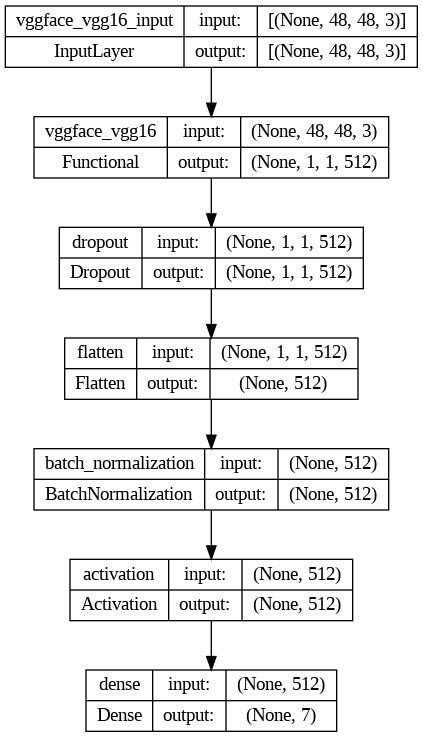

In [13]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import keras.backend as K

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [ ]:
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = 20,
                        verbose = 1,
                        factor = 0.50, 
                        min_lr = 1e-10)

mcp = ModelCheckpoint('fer_model_saved.h5')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=METRICS)

In [ ]:
history = model.fit(train_dataset, 
                    validation_data=valid_dataset,
                    epochs = 100,
                    verbose = 1,
                    callbacks=[lrd, mcp, es])

Epoch 1/100
359/359 [==============================] - 56s 117ms/step - loss: 1.8055 - accuracy: 0.8573 - precision: 0.5556 - recall: 0.0052 - auc: 0.6513 - f1_score: 0.0101 - val_loss: 1.8122 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6786 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/100
359/359 [==============================] - 39s 108ms/step - loss: 1.7295 - accuracy: 0.8584 - precision: 0.5645 - recall: 0.0377 - auc: 0.7013 - f1_score: 0.0691 - val_loss: 1.7553 - val_accuracy: 0.8573 - val_precision: 1.0000 - val_recall: 8.7093e-04 - val_auc: 0.7016 - val_f1_score: 0.0017 - lr: 0.0010
Epoch 3/100
359/359 [==============================] - 39s 108ms/step - loss: 1.6981 - accuracy: 0.8596 - precision: 0.6194 - recall: 0.0448 - auc: 0.7173 - f1_score: 0.0818 - val_loss: 1.8070 - val_accuracy: 0.8572 - val_precision: 1.0000 - val_recall: 1.7419e-04 - val_auc: 0.6725 - val_f1_score: 3.4188e-04 - lr: 0.0010
Epoch 4/100
359/359 [==========

In [ ]:
model.save('fer_model_tf.h5') 

# Model Test

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
my_model = tf.keras.models.load_model('/content/fer_model_tf.h5', custom_objects={'f1_score': f1_score})

# Show the model architecture
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                        

In [ ]:
my_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=METRICS)

In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/predict',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64,
                                                  shuffle=False)

Found 1 images belonging to 2 classes.


In [ ]:
emotion_dict = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

res = my_model.predict(test_dataset)
for ans in res:
    print('Answer for the 0 photo:', emotion_dict[np.argmax(ans)])

1/1 [==============================] - 1s 735ms/step
Answer for the 0 photo: angry


In [ ]:
res

array([[0.3401285 , 0.0396511 , 0.16722511, 0.01198076, 0.20423156,
        0.1596915 , 0.0770914 ]], dtype=float32)